# Sparse Matrix Recommender (SMR) Classification Workflow

Anton Antonov  
[PythonForPrediction at WordPress](https://pythonforprediction.wordpress.com)   
October 2025

---

## Setup

In [4]:
import pandas
import random
import numpy
from collections import Counter

from SparseMatrixRecommender import *
from SparseMatrixRecommender.DataLoaders import *
from ROCFunctions import *
from DataTypeSystem import *

In [46]:
import matplotlib.pyplot as plt

def plot_roc(fpr_list, tpr_list):
    plt.style.use('dark_background')
    plt.plot(fpr_list, tpr_list, label='ROC curve')
    plt.plot([0, 1], [0, 1], '--', color='dimgray', label='Random guess')

    plt.grid(color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

----

## Get data

In [6]:
dfData0 = load_mushroom_data_frame()
dfData0.shape

(8124, 24)

In [7]:
dfData0

,id,cap-Shape,cap-Surface,cap-Color,bruises?,odor,gill-Attachment,gill-Spacing,gill-Size,gill-Color,...,stalk-Color-Above-Ring,stalk-Color-Below-Ring,veil-Type,veil-Color,ring-Number,ring-Type,spore-Print-Color,population,habitat,edibility
0,id.1,convex,smooth,brown,True,pungent,free,close,narrow,black,...,white,white,partial,white,one,pendant,black,scattered,urban,poisonous
1,id.2,convex,smooth,yellow,True,almond,free,close,broad,black,...,white,white,partial,white,one,pendant,brown,numerous,grasses,edible
2,id.3,bell,smooth,white,True,anise,free,close,broad,brown,...,white,white,partial,white,one,pendant,brown,numerous,meadows,edible
3,id.4,convex,scaly,white,True,pungent,free,close,narrow,brown,...,white,white,partial,white,one,pendant,black,scattered,urban,poisonous
4,id.5,convex,smooth,gray,False,none,free,crowded,broad,black,...,white,white,partial,white,one,evanescent,brown,abundant,grasses,edible
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,id.8120,knobbed,smooth,brown,False,none,attached,close,broad,yellow,...,orange,orange,partial,orange,one,pendant,buff,clustered,leaves,edible
8120,id.8121,convex,smooth,brown,False,none,attached,close,broad,yellow,...,orange,orange,partial,brown,one,pendant,buff,several,leaves,edible
8121,id.8122,flat,smooth,brown,False,none,attached,close,broad,brown,...,orange,orange,partial,orange,one,pendant,buff,clustered,leaves,edible
8122,id.8123,knobbed,scaly,brown,False,fishy,free,close,narrow,buff,...,white,white,partial,white,one,evanescent,white,several,leaves,poisonous


-----

## Preliminary data analysis

In [8]:
cross_tabulate(dfData0, 'odor', 'edibility').print_matrix()

         |    edible poisonous
------------------------------
  almond |       400         .
   anise |       400         .
creosote |         .       192
   fishy |         .       576
    foul |         .      2160
   musty |         .        36
    none |      3408       120
 pungent |         .       256
   spicy |         .       576


----

## Make recommender

Split the data:

In [9]:
random_seed = 42
numpy.random.seed(random_seed)

shuffled_indices = numpy.random.permutation(len(dfData0))
split_point = int(len(dfData0) * 0.75)

train_indices = shuffled_indices[:split_point]
test_indices = shuffled_indices[split_point:]

dfTraining = dfData0.iloc[train_indices].reset_index(drop=True)
dfTesting = dfData0.iloc[test_indices].reset_index(drop=True)

print(dfTraining.shape)
print(dfTesting.shape)

(6093, 24)
(2031, 24)


Make the recommender with the training data:

In [10]:
smrObj = (SparseMatrixRecommender()
          .create_from_wide_form(dfTraining,
                                 item_column_name="id",
                                 columns=["cap-Shape", "cap-Surface", "cap-Color", "bruises?", "odor", "gill-Attachment", "gill-Spacing", "gill-Size", "gill-Color", "edibility"],
                                 add_tag_types_to_column_names=True,
                                 tag_value_separator=":")
          .apply_term_weight_functions("IDF", "None", "Cosine"))

The obtained recommender object:

In [11]:
smrObj

<Sparse matrix recommender object with matrix dimensions 6093x51
	and with 10 tag types>

Classify by profile:

In [12]:
recs = (smrObj
        .classify_by_profile('edibility', profile={"cap-Shape:convex": 1.2, "edibility:poisonous": 1.4}, n_top_nearest_neighbors=20)
        .take_value())

recs

{'edibility:poisonous': 1.0}

----

## Batch classification

In [13]:
n_top_nearest_neighbors = 20

noNNs = []

dfResults = []
for record in dfTesting.to_dict(orient='records'):
    prof = [(k, v) for k, v in record.items() if k not in ('id', 'edibility')]
    prof = [f"{k}:{v}" for k, v in prof]
    class_dict = smrObj.classify_by_profile(tag_type='edibility', profile=prof, n_top_nearest_neighbors = n_top_nearest_neighbors, ignore_unknown=True).take_value()
    class_dict = {k.replace('edibility:', ''): float(v) for k, v in class_dict.items()}

    if len(class_dict) == 0:
        noNNs.append(prof)

    predicted = max(class_dict, key=class_dict.get) if class_dict else None
    result = {'id': record['id'], 'actual': record['edibility'], 'predicted': predicted}
    result.update(class_dict)
    dfResults.append(result)

deduce_type(dfResults)

Vector(Struct([actual, edible, id, predicted], [str, float, str, str]), 2031)

In [14]:
Counter([len(row) for row in dfResults])

Counter({4: 1922, 5: 109})

In [15]:
empty = {'poisonous': 0, 'edible': 0}
dfResults = [{**empty, **res} for res in dfResults]

from collections import Counter
Counter(len(res) for res in dfResults)

Counter({5: 2031})

In [16]:
dfResults=pandas.DataFrame(dfResults)
dfResults

,poisonous,edible,id,actual,predicted
0,0.0,1.00000,id.3527,edible,edible
1,0.0,1.00000,id.2515,edible,edible
2,1.0,0.04908,id.5446,poisonous,poisonous
3,0.0,1.00000,id.1008,edible,edible
4,1.0,0.00000,id.4771,poisonous,poisonous
...,...,...,...,...,...
2026,1.0,0.00000,id.5227,poisonous,poisonous
2027,0.0,1.00000,id.5391,edible,edible
2028,0.0,1.00000,id.861,edible,edible
2029,1.0,0.00000,id.7604,poisonous,poisonous


-----

## Classifier metrics

In [17]:
cross_tabulate(dfResults, "actual", "predicted").print_matrix()

          |    edible poisonous
-------------------------------
   edible |      1074         2
poisonous |        13       942


In [37]:
thresholds = numpy.arange(0, 1.01, 0.01)

rocGroups = {}
for th in thresholds:
    rocGroups[th] = to_roc_dict('poisonous', 'edible',
                        list(dfResults.actual.values),
                        [('poisonous' if value >= th else 'edible') for value in list(dfResults.poisonous)]
)

deduce_type(rocGroups)

Assoc(Atom(<class 'float'>), Assoc(Atom(<class 'str'>), Atom(<class 'int'>), 4), 101)

The ROC curve plot:

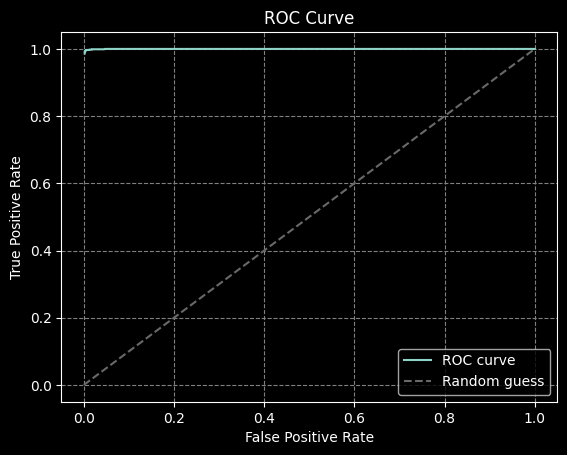

In [47]:
plot_roc(
    [roc_functions('FPR')(v) for (k, v) in rocGroups.items()],
    [roc_functions('TPR')(v) for (k, v) in rocGroups.items()]
)